Authors       | Email                  |
:--------------|:----------------------|
Rezwanul      | rezwanul.cse@gmail.com |


## Problem: Sentiment Analysis of Movie Reviews Using LSTM.
### Problem class: NLP, Sequential

#### The IMDb dataset is provided by IMDb.
### Problem dataset link: [IMDb dataset](https://www.imdb.com/)

### Problem description:

 Predicting the sentiment of movie reviews on IMDb.

### Problem Task:  Build and train a LSTM network to predict the sentiment of movie reviews on IMDb.

# Import Libraries

In [2]:
import os
import random
import shutil
import piexif
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, mean_squared_error

from keras.datasets import imdb
from keras.layers import Dense, Embedding, LSTM
from keras.models import Sequential
from keras.preprocessing import sequence

Using TensorFlow backend.


# Loading data

In [2]:
training_set, testing_set = imdb.load_data(index_from=3)
X_train, y_train = training_set
X_test, y_test = testing_set

In [3]:
# Print the first movie
print(X_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [4]:
# As dataset already encoded the words as number by keras we can decode it using keras word-to-index
word_to_id = imdb.get_word_index()
word_to_id = { key: (value+3) for key, value in word_to_id.items()}
word_to_id["<START>"] = 1
id_to_word = { value: key for key, value in word_to_id.items() }

#Insight: Clearly, the sentiment of this review is negative!

In [5]:
print(' '.join(id_to_word[id] for id in X_train[159])) ## 159 number review

<START> a rating of 1 does not begin to express how dull depressing and relentlessly bad this movie is


In [6]:
print(y_train[159])

## Insight: A y value of 0 refers to a negative review and a y value of 1 refers to a positive review. 

0


In [7]:
print(' '.join(id_to_word[id] for id in X_train[6])) ## 6 number review

<START> lavish production values and solid performances in this straightforward adaption of jane austen's satirical classic about the marriage game within and between the classes in provincial 18th century england northam and paltrow are a salutory mixture as friends who must pass through jealousies and lies to discover that they love each other good humor is a sustaining virtue which goes a long way towards explaining the accessability of the aged source material which has been toned down a bit in its harsh scepticism i liked the look of the film and how shots were set up and i thought it didn't rely too much on successions of head shots like most other films of the 80s and 90s do very good results


In [8]:
print(y_train[6])

## Insight: y value of 1 refers to a positive review.

1


In [9]:
# One-hot encoding cannot be use to encode the data so we can use word embeddings
## Word embeddings are a learned form of vector representation for words. The
## main advantage of word embeddings is that they have fewer dimensions than
## the one-hot encoded representation, and they place similar words close to one
## another

![word embeddings](images/word_embeddings.png)

In [10]:
# Notice that the learned word embedding knows that the words "Elated",
# "Happy", and "Excited" are similar words, and hence should be placed near
# each other. Similarly, the words "Sad", "Disappointed", "Angry", and
# "Furious" are on the opposite ends of the spectrum, and should be placed far
# away.

![model architecture](images/model_structure.png)

In [3]:
training_set, testing_set = imdb.load_data(num_words=10000)
# num_words: This is defined as the maximum number of unique words to be
# loaded. Only the n most common unique words (as they appear in the
# dataset) will be loaded. If n is small, the training time will be faster at the
# expense of accuracy.
X_train, y_train = training_set
X_test, y_test = testing_set

In [4]:
print(f"Number of training samples = {X_train.shape[0]}")
print(f"Number of testing samples = {X_test.shape[0]}")

Number of training samples = 25000
Number of testing samples = 25000


#### Zero padding process

In [13]:
# Movie reviews have different lengths, and therefore the input vectors have different sizes.
# This is an issue, as neural networks only accept fixed-size vectors.

# Define a maxlen parameter. The maxlen parameter shall be the maximum length of each movie review.
# Reviews that are longer than maxlen will be truncated, and reviews that are shorter than maxlen will be padded with zeros.

![zero padding](images/zero_padding.png)

In [5]:
X_train_padded = sequence.pad_sequences(X_train, maxlen=100)
X_test_padded = sequence.pad_sequences(X_test, maxlen=100)

In [6]:
print(f"X_train vector shape = {X_train_padded.shape}")
print(f"X_test vector shape = {X_test_padded.shape}")

X_train vector shape = (25000, 100)
X_test vector shape = (25000, 100)


# Model Building

In [16]:
model = Sequential()

In [17]:
## Note:
# The Embedding class takes the following important arguments:
# input_dim: The input dimensions of the word embedding layer. This
# should be the same as the num_words parameter that we used when we
# loaded in our data. Essentially, this is the maximum number of unique
# words in our dataset.
# output_dim: The output dimensions of the word embedding layer. This
# should be a hyperparameter to be fine-tuned. For now, we can use a value
# of 128.

In [18]:
model.add(Embedding(input_dim=10000, output_dim=128))

In [19]:
## Note: 
# The LSTM class takes the following important arguments:
# # units: This refers to the number of recurring units in the LSTM layer. A
# larger number of units results in a more complex model, at the expense
# of training time and overfitting. For now, let's use a typical value of 128
# for the number of units.
# # activation: This refers to the type of activation function applied to the cell
# state and the hidden state. The default value is the tanh function.
# # recurrent_activation: This refers to the type of activation function applied
# to the forget, input, and output gates. The default value is the sigmoid
# function.

In [20]:
model.add(LSTM(units=128))

In [21]:
model.add(Dense(units=1, activation='sigmoid'))

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 1,411,713
Trainable params: 1,411,713
Non-trainable params: 0
_________________________________________________________________


# Compiling and training models

In [23]:
# Trying the SGD optimizer as for LSTM, it is often impossible to know beforehand which optimizer
# will be better for the dataset
Optimizers = ['SGD', 'RMSprop', 'adam']

In [24]:
model.compile(loss='binary_crossentropy', optimizer=Optimizers[0])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [25]:
# scores = model.fit(x=X_train_padded, y=y_train, batch_size=128, epochs=10, validation_data=(X_test_padded, y_test))

In [7]:
def train_model(Optimizer, X_train, y_train, X_val, y_val):
    model = Sequential()
    model.add(Embedding(input_dim=10000, output_dim=128))
    model.add(LSTM(units=128))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Optimizer, metrics=['accuracy'])
    scores = model.fit(x=X_train, y=y_train, batch_size=128, epochs=10, validation_data=(X_val, y_val), verbose=0)
    
    return scores, model

In [9]:
SGD_score, SGD_model = train_model(Optimizer='sgd', 
                                   X_train=X_train_padded,
                                   y_train=y_train,
                                   X_val=X_test_padded,
                                   y_val=y_test
                                  )

In [8]:
RMSprop_score, RMSprop_model = train_model(Optimizer='RMSprop', 
                                   X_train=X_train_padded,
                                   y_train=y_train,
                                   X_val=X_test_padded,
                                   y_val=y_test
                                  )






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [11]:
Adam_score, Adam_model = train_model(Optimizer='adam', 
                                   X_train=X_train_padded,
                                   y_train=y_train,
                                   X_val=X_test_padded,
                                   y_val=y_test
                                  )

# Analyzing the results

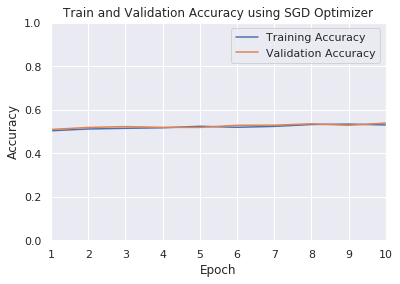

In [11]:
## SGD Optimizer result with graph
plt.plot(range(1, 11), SGD_score.history['acc'], label='Training Accuracy')
plt.plot(range(1, 11), SGD_score.history['val_acc'], label='Validation Accuracy')
plt.axis([1, 10, 0, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy using SGD Optimizer')
plt.legend()
plt.show()

## Insight: 
# The training and validation accuracy is stuck at 50%! Essentially, this shows that 
# the training has failed and our neural network performs no better than a random coin 
# toss for this binary classification task. Clearly, the sgd optimizer is not suitable 
# for this dataset and this LSTM network.

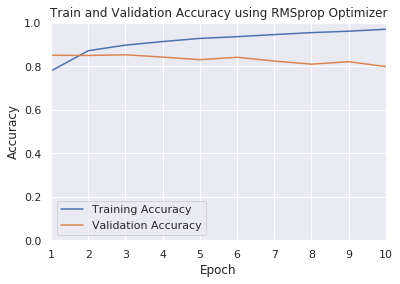

In [10]:
# RMSprop Optimizer result with graph
plt.plot(range(1, 11), RMSprop_score.history['acc'], label='Training Accuracy')
plt.plot(range(1, 11), RMSprop_score.history['val_acc'], label='Validation Accuracy')
plt.axis([1, 10, 0, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy using RMSprop Optimizer')
plt.legend()
plt.show()

## Insight:
# Within 10 epochs, our model is able to achieve a training accuracy of more than 95% 
# and a validation accuracy of around 85%. That's not bad at all. Clearly, the RMSprop 
# optimizer performs better than the sgd optimizer for this task.

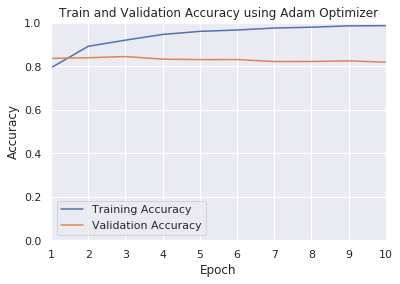

In [12]:
# Adam Optimizer result with graph
plt.plot(range(1, 11), Adam_score.history['acc'], label='Training Accuracy')
plt.plot(range(1, 11), Adam_score.history['val_acc'], label='Validation Accuracy')
plt.axis([1, 10, 0, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy using Adam Optimizer')
plt.legend()
plt.show()

## Insight:
# The adam optimizer does pretty well. From the preceding graph, we can see that the 
# Training Accuracy is almost 100% after 10 epochs, while the Validation Accuracy is 
# around 80%. This gap of 20% suggests that overfitting is happening when the adam 
# optimizer is used.

# Confusion matrix

Text(56.499999999999986, 0.5, 'Actual')

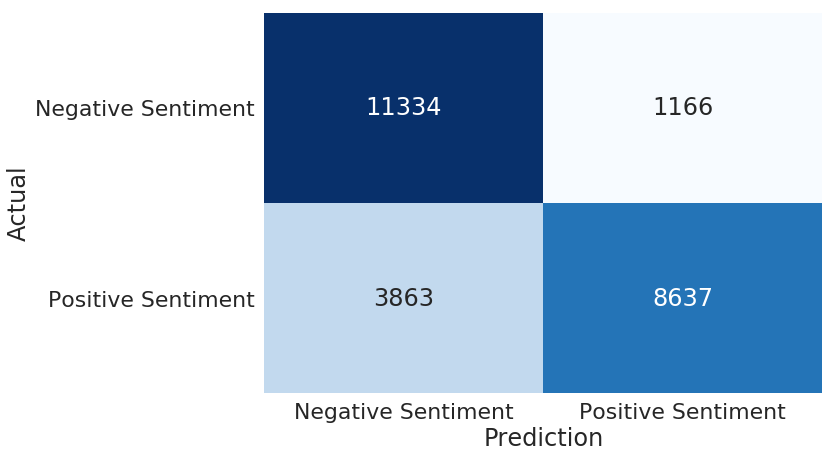

In [14]:
plt.figure(figsize=(10, 7))
sns.set(font_scale=2)
y_test_pred = RMSprop_model.predict_classes(X_test_padded)
c_matrix = confusion_matrix(y_test, y_test_pred)
ax = sns.heatmap(c_matrix, annot=True, 
                 xticklabels=['Negative Sentiment', 'Positive Sentiment'],
                 yticklabels=['Negative Sentiment', 'Positive Sentiment'],
                 cbar=False, cmap='Blues', fmt='g'
                )
ax.set_xlabel('Prediction')
ax.set_ylabel('Actual')

## Insight:
# From the preceding confusion matrix, we can see that most of the testing data
# was classified correctly, with the number of true negatives and true positives
# at around 85%. In other words, our model is 85% accurate at predicting
# sentiment for movie reviews.

In [16]:
false_negatives = []
false_positives = []

for i in range(len(y_test_pred)):
    if y_test_pred[0] != y_test[i]:
        if y_test[i] == 0: # False Positive
            false_positives.append(i)
        else:
            false_negatives.append(i)

In [ ]:
# false positives refer to movie reviews that were negative but that our model wrongly 
# classified as positive.